# Tech Challenge 03 - Machine Learning Engineering

O projeto contempla a criação das APIs para gestão de Produção, Processamento, Comercialização, Importação e Exportação contida no site da Embrapa, possibilitando listar, localizar, cadastrar, atualizar, excluir e realizar o scraping dos dados da Vitivinicultura da Embrapa.

Para mais informações para obter os dados e execução das APIs basta acessar o [Link do Github](https://github.com/claudio-pandolfi/tc01-fiap)

### Instalação das dependências

In [2]:
pip install mongoengine matplotlib pandas numpy scikit-learn ipywidgets IPython

Note: you may need to restart the kernel to use updated packages.


### Importar bibliotecas

In [3]:
import matplotlib.pyplot as plt
from mongoengine import connect, disconnect, Document, ObjectIdField, StringField, IntField, FloatField
import numpy as np
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import IsolationForest
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import root_mean_squared_error, mean_absolute_percentage_error
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from ipywidgets import widgets



### Carregando dados - Vitivinicultura da Embrapa

In [4]:
disconnect(alias='default')

connect(host="mongodb://localhost:27017/database")

class Importation(Document):
    _id = ObjectIdField()
    country = StringField(required=True)
    product = StringField(required=True)
    year = IntField(required=True)
    quantity = IntField(required=True)
    amount = FloatField(precision=2)

    def to_dict(self):
        return {
            '_id': str(self._id),
            'country': self.country,
            'product': self.product,
            'year': self.year,
            'quantity': self.quantity,
            'amount': self.amount
        }
    

aggregate = [
    {
        "$group": {
            "_id": {"product": "$product", "year": "$year"},
            "total_amount": {"$sum": "$amount"},
            "total_quantity": {"$sum": "$quantity"}
        }
    },
    {
        "$sort": {"_id.product": 1, "_id.year": 1}
    }
]


ExportationDataByProduct = [[exportation_data["_id"]["product"],exportation_data["_id"]["year"], exportation_data["total_amount"], exportation_data["total_quantity"]] for exportation_data in Importation.objects().aggregate(aggregate)]
df = pd.DataFrame(ExportationDataByProduct)
df.columns = ["product", "year", "total_amount", "total_quantity"]


In [5]:
disconnect(alias='default')

connect(host="mongodb://localhost:27017/database")

class Importation(Document):
    _id = ObjectIdField()
    country = StringField(required=True)
    product = StringField(required=True)
    year = IntField(required=True)
    quantity = IntField(required=True)
    amount = FloatField(precision=2)

    def to_dict(self):
        return {
            '_id': str(self._id),
            'country': self.country,
            'product': self.product,
            'year': self.year,
            'quantity': self.quantity,
            'amount': self.amount
        }
    

aggregate = [
    {
        "$group": {
            "_id": {"product": "$product", "year": "$year"},
            "total_amount": {"$sum": "$amount"},
            "total_quantity": {"$sum": "$quantity"}
        }
    },
    {
        "$sort": {"_id.product": 1, "_id.year": 1}
    }
]


ExportationDataByProduct = [[exportation_data["_id"]["product"],exportation_data["_id"]["year"], exportation_data["total_amount"], exportation_data["total_quantity"]] for exportation_data in Importation.objects().aggregate(aggregate)]
df = pd.DataFrame(ExportationDataByProduct)
df.columns = ["product", "year", "total_amount", "total_quantity"]


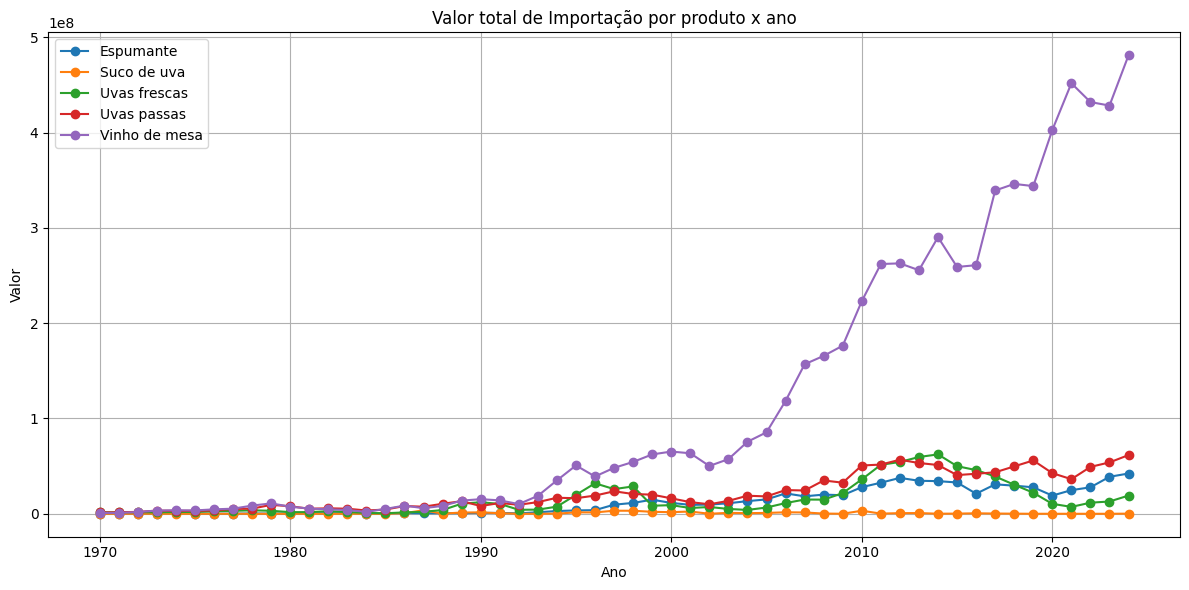

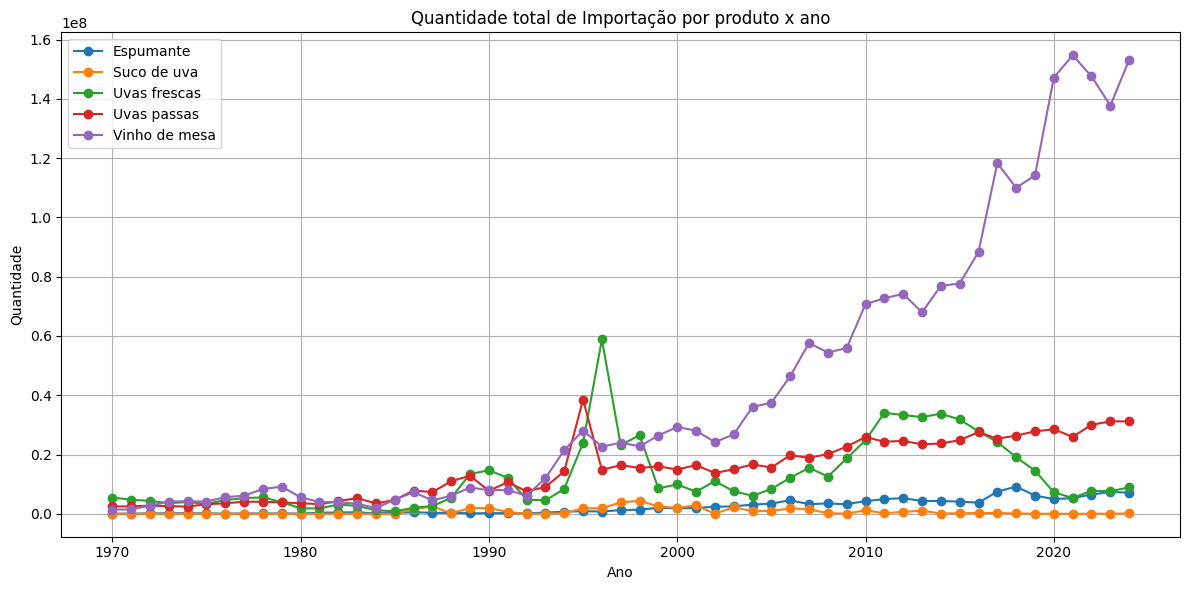

In [6]:
plt.figure(figsize=(12, 6))

for product in df['product'].unique():
    subset = df[df['product'] == product]
    plt.plot(subset['year'], subset['total_amount'], label=product, marker='o')

plt.title('Valor total de Importação por produto x ano')
plt.xlabel('Ano')
plt.ylabel('Valor')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 6))

for product in df['product'].unique():
    subset = df[df['product'] == product]
    plt.plot(subset['year'], subset['total_quantity'], label=product, marker='o')

# Customize chart
plt.title('Quantidade total de Importação por produto x ano')
plt.xlabel('Ano')
plt.ylabel('Quantidade')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Preparação e Tratamento dos dados 

In [7]:
df.dropna() 

subsets = {}

for product in df['product'].unique():
    subsets[product] = df[df['product'] == product].drop("product", axis=1)

subsets

{'Espumante':     year  total_amount  total_quantity
 0   1970       62301.0           38313
 1   1971       91736.0           49964
 2   1972      169053.0          120124
 3   1973      293639.0          168040
 4   1974      435151.0          172548
 5   1975      180623.0          122805
 6   1976      115763.0           62430
 7   1977      177290.0           86871
 8   1978      314778.0          109331
 9   1979      285328.0          111681
 10  1980      179108.0           86029
 11  1981      519056.0          367586
 12  1982      560370.0          467907
 13  1983      549052.0          492272
 14  1984      212714.0          166935
 15  1985      412621.0          312841
 16  1986      739317.0          575325
 17  1987      487983.0          300048
 18  1988      605465.0          332971
 19  1989      632150.0          167763
 20  1990      956496.0          206637
 21  1991      927142.0          216945
 22  1992      468810.0          114187
 23  1993     1602190.0    

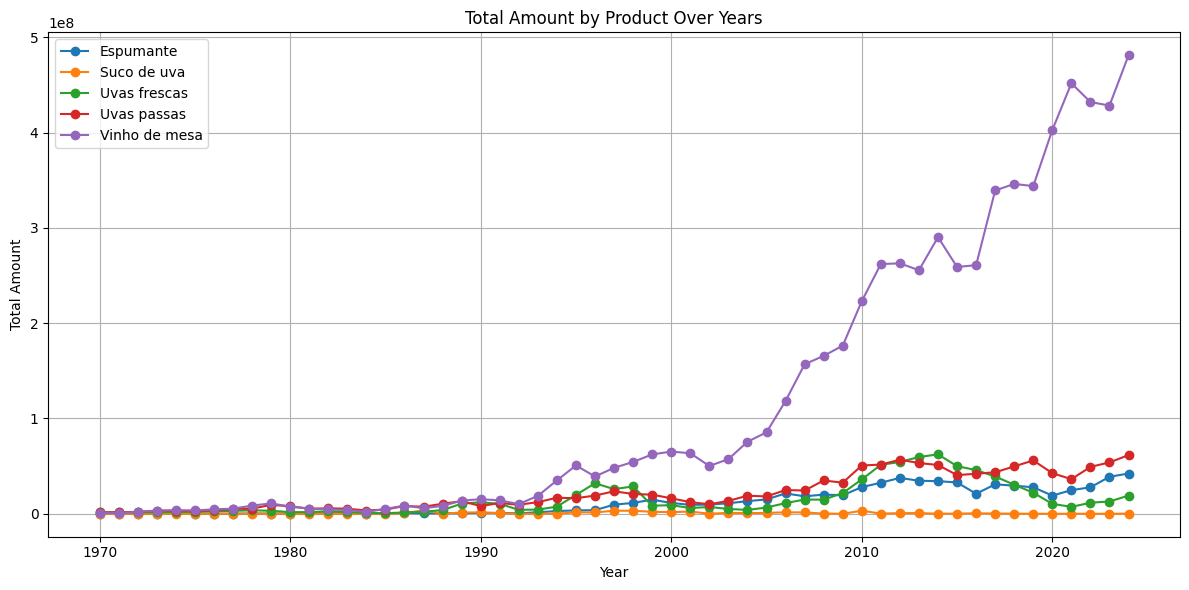

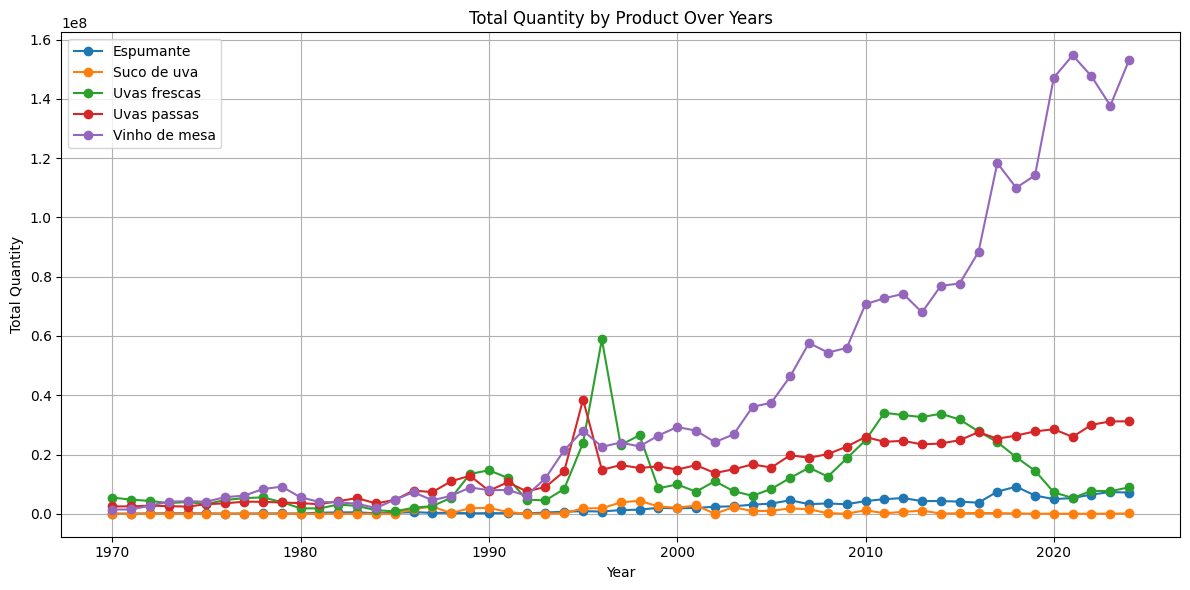

In [8]:
# Gráfico baseado no valor
plt.figure(figsize=(12, 6))

for product, subset in subsets.items():
    plt.plot(subset['year'], subset['total_amount'], label=product, marker='o')

# Customize chart
plt.title('Total Amount by Product Over Years')
plt.xlabel('Year')
plt.ylabel('Total Amount')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Gráfico baseado na quantidade
plt.figure(figsize=(12, 6))

for product, subset in subsets.items():
    plt.plot(subset['year'], subset['total_quantity'], label=product, marker='o')

# Customize chart
plt.title('Total Quantity by Product Over Years')
plt.xlabel('Year')
plt.ylabel('Total Quantity')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## Treinamento Supervisionado - Modelo de Regressão

Foi escolhido os Modelos de Regressão para análise preditiva de valores para os produtos da vitivinicultura da Embrapa

### Modelo de regressão linear


In [ ]:


for product, subset in subsets.items():
    print('################################################################')
    print(f'Teste do produto {product}')
    x = pd.DataFrame(subset["year"]).apply(pd.to_numeric, errors="coerce")
    y = pd.DataFrame(subset["total_amount"]).apply(pd.to_numeric, errors="coerce")
    
    min_max_scaler = StandardScaler()
    
    min_max_scaler.fit_transform(x)

    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=23)

    print(f'Exemplos para o treinamento: {len(y_train)}. E para o teste: {len(y_test)}')
    
    model = LinearRegression()
    model.fit(x_train, y_train)

    y_pred = model.predict(x_test)
    
    mse = root_mean_squared_error(y_test,y_pred)
    rmse = np.sqrt(mse)
    mape = mean_absolute_percentage_error(y_test,y_pred)

    print(f'MSE: {mse} | RMSE: {rmse} | MAPE: {mape}')
    
    print('################################################################')

################################################################
Teste do produto Espumante
Exemplos para o treinamento: 38. E para o teste: 17
MSE: 5429439.849733022 | RMSE: 2330.1158447023663 | MAPE: 5.097598539470844
################################################################
################################################################
Teste do produto Suco de uva
Exemplos para o treinamento: 38. E para o teste: 17
MSE: 966564.6140247247 | RMSE: 983.1401802513844 | MAPE: 4.358977766765679e+20
################################################################
################################################################
Teste do produto Uvas frescas
Exemplos para o treinamento: 38. E para o teste: 17
MSE: 12678628.126484187 | RMSE: 3560.7061275095684 | MAPE: 2.5279223614438076
################################################################
################################################################
Teste do produto Uvas passas
Exemplos para o treinamento: 38. E para o